### Read data (wav)
First read in high cavitation files.

In [2]:
def read_wav(dataset_names):
    samplerate = []
    df = []
    for data in dataset_names:
        path =  Path.cwd()/"data"
        sf, d = wavfile.read(path/data)
        samplerate.append(sf)
        df.append(d)
    return samplerate , df

In [3]:
datasets = ["s00000_191115_007_KesselpumpHD02_002_RP1_FC_01_P06_SB1_L0_KS_XXXX_YY_YYYY_ZZZZZZ_16.wav"]
#,"sxmany_200206_007_HKMNetzpumpe04_004_RP1_FC_01_C06_SB1_L0_XX_XXXX_YY_YYYY_ZZZZZZ_10.wav"
sr, df = read_wav(datasets)

C:\Users\kinos\AppData\Local\Temp\ipykernel_2416\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


## Splitting

Splitting the data in 2 second samples

In [4]:

def splitting (sr, df, sec):
    seg_len = sr * sec

    #split_list = []
    splits = []
    for data in df:
        sections = int(np.ceil(len(data) / seg_len))

        for i in range(sections):
            t = data[i * seg_len: (i + 1) * seg_len]
            splits.append(t)
        #split_list.append(splits)

    return splits

In [5]:
df_split = splitting(sr[0],df, 3)


## Fourier Transformation

Transform data into frequency domain.

In [6]:
from scipy.fftpack import fft, ifft

def fourier_trans(sr, data):
    df_ftt = []
    freq = []
    for i in data:

        length = i.shape[0] / sr
        N = i.shape[0]
        n = np.arange(N)
        freq.append(n/length)
        df_ftt.append(fft(i))

    return freq, df_ftt

In [7]:
freq, df_ftt = fourier_trans(sr[0],df_split)

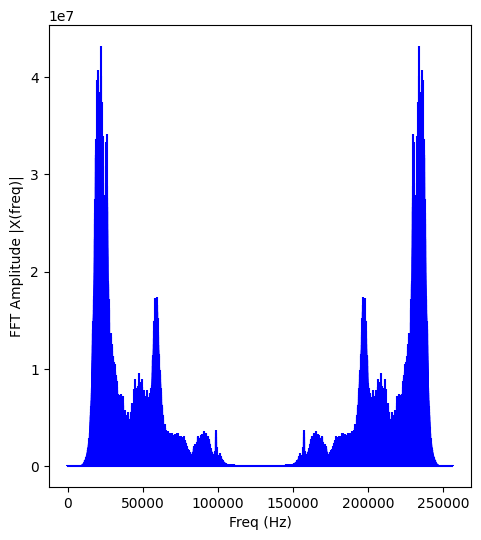

In [8]:
    plt.figure(figsize = (12, 6))
    plt.subplot(121)


    plt.stem(freq[1], np.abs(df_ftt[1]), 'b', \
             markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')

    plt.show()

## Feature extraction and labels

Extract statistical features and add a label.

In [9]:
import os
import scipy.io as scio
from scipy.stats import norm, kurtosis, skew
import pandas as pd
import math
import csv
'''
1. Central Trend Statistics:
   --- mean
   --- median
   --- low quartile
   --- upper quartile
2. Dispersion Degree Statistics:
   --- minimum
   --- maximum
   --- inter quartile range
   --- standard deviation
   --- root mean square
   --- square root amplitude
3. Distribution Shape Statistics
   --- kurtosis
   --- skewness
   --- shape factor
   --- clearance shape
   --- crest factor
'''


def feature_extraction(df, label):
    column_name = ["mean", "median", "quartile_25", "quartile_75", "Max", "Min", "quartile", "std", "rms", "sra", "kurtosis", "skew", "ff", "clf", "cf", "Cavitation"]

    df_features = pd.DataFrame(columns = column_name) #
    for data in df:
        feature_list = []

           # central trend statistics
        data_mean = np.mean(data)
        data_median = np.median(data)
        data_quartile_025 = np.quantile(data, 0.25)
        data_quartile_075 = np.quantile(data, 0.75)

           # dispersion degree statistics
        data_Minimum = np.min(data)
        data_Maximum = np.max(data)
        data_quartile = data_quartile_075 - data_quartile_025
        data_std = np.std(data)
        data_rms = np.sqrt((np.mean(data**2)))
        data_sra = (np.sum(np.sqrt(np.abs(data)))/len(data))**2

           # distribution shape statistics
        data_kurtosis = kurtosis(data)
        data_skew = skew(data)

        data_avg = np.mean(np.abs(data))
        data_ff = data_rms / data_avg

        data_clf = np.max(np.abs(data)) / data_sra
        data_cf = np.max(np.abs(data)) / data_rms

        feature_list = [data_mean, data_median, data_quartile_025, data_quartile_075, data_Maximum, data_Minimum, data_quartile, data_std, data_rms, data_sra, data_kurtosis, data_skew, data_ff, data_clf, data_cf, label]
        feature_list = pd.DataFrame(data=feature_list).T #,
        feature_list.columns = column_name

        df_features = pd.concat([df_features,feature_list])

    return df_features











In [10]:
h_c_df = feature_extraction(df_ftt, "High_cavitation")

In [11]:
h_c_df

,mean,median,quartile_25,quartile_75,Max,Min,quartile,std,rms,sra,kurtosis,skew,ff,clf,cf,Cavitation
0,(132.99956-0.0014026692j),(-8402.701+2022.0864j),(-331655.6875-709734.25j),(324030.5859375-92091.46875j),(29593094+10988780j),(-31842952-402221.56j),(655686.2734375+617642.78125j),3347851.25,(178311.27+0.0031129385j),983584.26115,(7040.52169551915-0.003528467653576564j),(-82.66925144443127+8.26214124553411e-06j),(0.10342599+1.8055996e-09j),38.850296,(214.30244-3.7412685e-06j),High_cavitation
0,(7773+4.2317708e-05j),(9234.221+2076.7935j),(-337361.15625-1879961.75j),(349140.2734375-5015.015625j),(39313530+10657516j),(-43164050-2777041.5j),(686501.4296875+1874946.734375j),3600572.75,(63768.7-0.059337784j),1035275.894806,(3272236.705223027-2.6256279806752683j),(4103.089095024171-0.002589204920695049j),(0.035048608-3.2613286e-08j),41.779479,(678.284+0.000631154j),High_cavitation
0,(-3872.9993+0.00017871094j),(-1392.1553+0j),(-358001.203125-319601.484375j),(359122.953125+64002.375j),(52536470+25293664j),(-39421984-919539.9j),(717124.15625+383603.859375j),3896459.5,(97768.88+0.017005028j),1071007.488543,(-353953.6586428361-0.14337254976106495j),(3996.1183364783674+0.001430019774330518j),(0.05067854+8.814563e-09j),54.442417,(596.3885-0.00010373038j),High_cavitation
0,(-6543-1.8229166e-05j),(-7365.1035+0j),(-363152.8046875+55845.8125j),(357423.125-121367.9140625j),(38962210+7579948.5j),(-43524230-3949310j),(720575.9296875-177213.7265625j),3881907.75,(0.009448715+197390.66j),1075550.828352,NaN,NaN,(4.9056252e-09+0.102482155j),48.104516,(1.2546897e-05-262.11398j),High_cavitation
0,(3593.9998+0.0006686198j),(6415.8555+0j),(-357414.7890625-978920.125j),(362113.5078125+16311.5625j),(45365852+13460658j),(-43049616-1993960.8j),(719528.296875+995231.6875j),3853040.75,(0.033212177-119697.14j),1084553.186421,NaN,NaN,(1.7263796e-08-0.062218953j),43.631527,(0.00010969354+395.337j),High_cavitation
0,(-5400.001-0.00049153646j),(-6235.2344+0j),(-366996.7265625-273471.5703125j),(358989.0390625+281348.03125j),(46404484+17311270j),(-44301696-9937717j),(725985.765625+554819.6015625j),3878199.75,(293643.66+0.010175198j),1084085.98683,(-4774.07215991948+0.000716724161604341j),(-13.942465590866313-7.55732272775895e-07j),(0.1518445+5.2616422e-09j),45.686723,(168.66815-5.8446076e-06j),High_cavitation
0,(5450.999+0.00037792968j),(7383.117+0j),(-281924.9296875-761292.15625j),(292544.578125+156431.4765625j),(28607680+5291485.5j),(-38160490-1154218.6j),(574469.5078125+917723.6328125j),3004322.25,(172298.03+0.0055954903j),854718.277845,(3098.233102540008-0.00456102613055287j),(-61.45822969493291+6.942567972231796e-06j),(0.113651164+3.6908951e-09j),44.667279,(221.58083-7.1959803e-06j),High_cavitation


## Same procedure for non-cavitation data.

Load file

In [12]:
datasets = ["sxmany_200206_007_HKMNetzpumpe04_004_RP1_FC_01_C06_SB1_L0_XX_XXXX_YY_YYYY_ZZZZZZ_10.wav"]

sr, df = read_wav(datasets)

C:\Users\kinos\AppData\Local\Temp\ipykernel_2416\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


### Split file

In [13]:
df_split = splitting(sr[0],df, 2)

### Fourier transformation

In [14]:
freq, df_ftt = fourier_trans(sr[0],df_split)

### Feature extraction and add labels

In [15]:
n_c_df = feature_extraction(df_ftt, "No_cavitation")

In [16]:
n_c_df

,mean,median,quartile_25,quartile_75,Max,Min,quartile,std,rms,sra,kurtosis,skew,ff,clf,cf,Cavitation
0,(189.00003-2.6135445e-05j),(285.6172+0j),(-47249.1669921875-23157.3037109375j),(47166.263671875+38939.90234375j),(3911730+337614.38j),(-3661461.8-932100.4j),(94415.4306640625+62097.2060546875j),488590.65625,(0.00030337693-39125.55j),173445.881346,NaN,NaN,(1.0527966e-09-0.1357758j),23.184109,(7.9692234e-07+102.77653j),No_cavitation
0,(338.99994+4.6318055e-05j),(442.60645-1.6757812j),(-50010.841796875-14338.849609375j),(50798.1943359375+9380.140625j),(3785041.2+2757947j),(-3834865-231807.61j),(100809.0361328125+23718.990234375j),534752.375,(3735.513+0.045838665j),186286.328881,(-13265830.836041898-1018.0839602872917j),(-14022.696349644491-0.8073015925038299j),(0.011945833+1.4658792e-07j),25.140049,(1253.7094-0.0153843295j),No_cavitation
0,(130.00005+5.081177e-06j),(116.10547-872.4668j),(-49651.80859375-6787.7763671875j),(50475.595703125+18213.83203125j),(3968321.2+418925.3j),(-4272759-52666.78j),(100127.404296875+25001.6083984375j),538714.5,(0.0059755296-8752.074j),186719.025093,NaN,NaN,(1.9044199e-08-0.027893135j),23.373341,(0.00034045818+498.65292j),No_cavitation
0,(-108.00001-1.1047363e-05j),(-422.4375+0j),(-44462.8818359375+580.0703125j),(44095.830078125-252996.4375j),(3280548.5+1183302.8j),(-3466732-795154.94j),(88558.7119140625-253576.5078125j),461055.5625,(0.003064022-15845.906j),160745.26583,NaN,NaN,(1.1415548e-08-0.059036687j),26.382631,(5.1750438e-05+267.63272j),No_cavitation
0,(-486-0.00011196899j),(778.2012+34.460938j),(-56428.169921875-23419.48828125j),(54220.0791015625+78690.03125j),(5136561.5+1732015.4j),(-4814440-267194.88j),(110648.2490234375+102109.51953125j),628457.75,(31533.066-0.0011302315j),214693.541053,(3333.563235543394-0.003744596583035472j),(37.95726114999959-2.4709416967138243e-05j),(0.0868481-3.112874e-09j),25.248612,(171.9057+6.161572e-06j),No_cavitation
0,(-243.00009+9.6466065e-05j),(-893.90625+66.1416j),(-54796.658203125-56730.4140625j),(55363.0517578125-47339.5703125j),(4646875+1764614.9j),(-5107823-285694.97j),(110159.7099609375+9390.84375j),577104.875,(77137.24+0.00065681024j),205354.467083,(574.1062690464822-5.298975392962457e-05j),(5.252818300098855-5.401803800617652e-07j),(0.22813512+1.942531e-09j),24.912078,(66.32084-5.647104e-07j),No_cavitation
0,(141.99995-6.6467284e-05j),(265.41406-6783.5547j),(-52241.9091796875+83787.2734375j),(51704.7509765625+21008.06640625j),(4342194+405774.7j),(-4544057.5-20420.531j),(103946.66015625-62779.20703125j),570660.9375,(0.003617974+19663.139j),195369.663166,NaN,NaN,(1.0906645e-08+0.059275962j),23.721198,(4.336641e-05-235.68985j),No_cavitation
0,(-116.00003+3.366661e-05j),(736.7539-78.39844j),(-53944.6796875+177818.15625j),(54024.5859375-7816.3984375j),(4522007.5+468985.3j),(-4376049.5-1115577.9j),(107969.265625-185634.5546875j),559219.875,(0.0035841372+14613.5j),196387.10185,NaN,NaN,(1.0933798e-08+0.04458006j),23.149494,(7.630107e-05-311.10016j),No_cavitation
0,(-369.99988+0.00011157226j),(-646.8076+0j),(-45643.9580078125-10078.8125j),(44771.3173828125+8318.427734375j),(4009059.2+256796.75j),(-4061546.2-2280218j),(90415.275390625+18397.240234375j),491752.65625,(14337.999+0.00065394957j),169149.798923,(24016.78919486427+0.018832068727827604j),(194.42952299994462+0.0001700003238607502j),(0.0502803+2.2932614e-09j),28.887049,(340.78943-1.554325e-05j),No_cavitation
0,(-294.0001-5.3009033e-05j),(-497.06348-67.24902j),(-51091.9404296875-30785.869140625j),(50301.43359375+10756.39453125j),(4094237+1327381.8j),(-4902808-1658628.6j),(101393.3740234375+41542.263671875j),546348.4375,(0.002013737-26406.824j),190932.976511,NaN,NaN,(6.284291e-09-0.08240806j),27.107774,(1.4946697e-05+196.00114j),No_cavitation


### Combine both datasets

In [17]:
final_df = pd.concat([h_c_df, n_c_df])

In [18]:
final_df

,mean,median,quartile_25,quartile_75,Max,Min,quartile,std,rms,sra,kurtosis,skew,ff,clf,cf,Cavitation
0,(132.99956-0.0014026692j),(-8402.701+2022.0864j),(-331655.6875-709734.25j),(324030.5859375-92091.46875j),(29593094+10988780j),(-31842952-402221.56j),(655686.2734375+617642.78125j),3347851.25,(178311.27+0.0031129385j),983584.26115,(7040.52169551915-0.003528467653576564j),(-82.66925144443127+8.26214124553411e-06j),(0.10342599+1.8055996e-09j),38.850296,(214.30244-3.7412685e-06j),High_cavitation
0,(7773+4.2317708e-05j),(9234.221+2076.7935j),(-337361.15625-1879961.75j),(349140.2734375-5015.015625j),(39313530+10657516j),(-43164050-2777041.5j),(686501.4296875+1874946.734375j),3600572.75,(63768.7-0.059337784j),1035275.894806,(3272236.705223027-2.6256279806752683j),(4103.089095024171-0.002589204920695049j),(0.035048608-3.2613286e-08j),41.779479,(678.284+0.000631154j),High_cavitation
0,(-3872.9993+0.00017871094j),(-1392.1553+0j),(-358001.203125-319601.484375j),(359122.953125+64002.375j),(52536470+25293664j),(-39421984-919539.9j),(717124.15625+383603.859375j),3896459.5,(97768.88+0.017005028j),1071007.488543,(-353953.6586428361-0.14337254976106495j),(3996.1183364783674+0.001430019774330518j),(0.05067854+8.814563e-09j),54.442417,(596.3885-0.00010373038j),High_cavitation
0,(-6543-1.8229166e-05j),(-7365.1035+0j),(-363152.8046875+55845.8125j),(357423.125-121367.9140625j),(38962210+7579948.5j),(-43524230-3949310j),(720575.9296875-177213.7265625j),3881907.75,(0.009448715+197390.66j),1075550.828352,NaN,NaN,(4.9056252e-09+0.102482155j),48.104516,(1.2546897e-05-262.11398j),High_cavitation
0,(3593.9998+0.0006686198j),(6415.8555+0j),(-357414.7890625-978920.125j),(362113.5078125+16311.5625j),(45365852+13460658j),(-43049616-1993960.8j),(719528.296875+995231.6875j),3853040.75,(0.033212177-119697.14j),1084553.186421,NaN,NaN,(1.7263796e-08-0.062218953j),43.631527,(0.00010969354+395.337j),High_cavitation
0,(-5400.001-0.00049153646j),(-6235.2344+0j),(-366996.7265625-273471.5703125j),(358989.0390625+281348.03125j),(46404484+17311270j),(-44301696-9937717j),(725985.765625+554819.6015625j),3878199.75,(293643.66+0.010175198j),1084085.98683,(-4774.07215991948+0.000716724161604341j),(-13.942465590866313-7.55732272775895e-07j),(0.1518445+5.2616422e-09j),45.686723,(168.66815-5.8446076e-06j),High_cavitation
0,(5450.999+0.00037792968j),(7383.117+0j),(-281924.9296875-761292.15625j),(292544.578125+156431.4765625j),(28607680+5291485.5j),(-38160490-1154218.6j),(574469.5078125+917723.6328125j),3004322.25,(172298.03+0.0055954903j),854718.277845,(3098.233102540008-0.00456102613055287j),(-61.45822969493291+6.942567972231796e-06j),(0.113651164+3.6908951e-09j),44.667279,(221.58083-7.1959803e-06j),High_cavitation
0,(189.00003-2.6135445e-05j),(285.6172+0j),(-47249.1669921875-23157.3037109375j),(47166.263671875+38939.90234375j),(3911730+337614.38j),(-3661461.8-932100.4j),(94415.4306640625+62097.2060546875j),488590.65625,(0.00030337693-39125.55j),173445.881346,NaN,NaN,(1.0527966e-09-0.1357758j),23.184109,(7.9692234e-07+102.77653j),No_cavitation
0,(338.99994+4.6318055e-05j),(442.60645-1.6757812j),(-50010.841796875-14338.849609375j),(50798.1943359375+9380.140625j),(3785041.2+2757947j),(-3834865-231807.61j),(100809.0361328125+23718.990234375j),534752.375,(3735.513+0.045838665j),186286.328881,(-13265830.836041898-1018.0839602872917j),(-14022.696349644491-0.8073015925038299j),(0.011945833+1.4658792e-07j),25.140049,(1253.7094-0.0153843295j),No_cavitation
0,(130.00005+5.081177e-06j),(116.10547-872.4668j),(-49651.80859375-6787.7763671875j),(50475.595703125+18213.83203125j),(3968321.2+418925.3j),(-4272759-52666.78j),(100127.404296875+25001.6083984375j),538714.5,(0.0059755296-8752.074j),186719.025093,NaN,NaN,(1.9044199e-08-0.027893135j),23.373341,(0.00034045818+498.65292j),No_cavitation


In [20]:

def feature_pipe (datasets, splits_in_sec, label):
    sr, df = read_wav(datasets)
    df_split = splitting(sr[0],df, splits_in_sec)
    freq, df_ftt = fourier_trans(sr[0],df_split)
    output_df = feature_extraction(df_ftt, label)
    return output_df

In [25]:
No_cav_files = ["sxmany_200206_007_HKMNetzpumpe04_004_RP1_FC_01_C06_SB1_L0_XX_XXXX_YY_YYYY_ZZZZZZ_10.wav"]
cav_files = ["s00000_191115_007_KesselpumpHD02_002_RP1_FC_01_P06_SB1_L0_KS_XXXX_YY_YYYY_ZZZZZZ_16.wav"]


no_cav_df = feature_pipe(No_cav_files,3,"No_Cavitation")
cav_df = feature_pipe(cav_files,3,"Cavitation")
final_df = pd.concat([no_cav_df, cav_df])
final_df

C:\Users\kinos\AppData\Local\Temp\ipykernel_2416\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2416\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


,mean,median,quartile_25,quartile_75,Max,Min,quartile,std,rms,sra,kurtosis,skew,ff,clf,cf,Cavitation
0,(188.99994-3.8457234e-05j),(654.5874-27.880615j),(-59563.97265625+29760.6171875j),(60535.78125+140140.546875j),(4502440+769062j),(-4749656-855067.6j),(120099.75390625+110379.9296875j),623193.0,(0.001463664+23716.791j),219598.065667,NaN,NaN,(4.005626e-09+0.064906016j),26.904506,(1.5373866e-05-249.11371j),No_Cavitation
0,(69.99999+3.6061606e-06j),(207.46844-112.16675j),(-60627.9501953125-24255.970703125j),(60336.66015625+186620.38671875j),(4586223+342420.06j),(-5260944.5-3829056.2j),(120964.6103515625+210876.357421875j),653088.6875,(0.00017643375-33207.297j),226534.391577,NaN,NaN,(4.6242848e-10-0.0870355j),28.723491,(1.0410845e-06+195.94664j),No_Cavitation
0,(-107.999916+4.0479023e-05j),(-598.29517+0j),(-55728.2109375-60218.1640625j),(54450.6943359375+47286.98828125j),(5333375+1489994.9j),(-4342060-62125.438j),(110178.9052734375+107505.15234375j),579544.9375,(0.014282511+3943.7744j),200960.337796,NaN,NaN,(4.226627e-08+0.011670821j),27.797607,(0.0051297736-1416.4646j),No_Cavitation
0,(95.99995+5.3059895e-05j),(34.46865+0j),(-70438.90625+7498.5546875j),(70460.470703125-60998.12109375j),(5806272.5+941386.9j),(-6467280-725592.5j),(140899.376953125-68496.67578125j),777630.6875,(30543.227+0.0022708517j),270172.721112,(5933.747889869698+0.0002542690552520374j),(-114.19503798862581+4.1220218041467913e-07j),(0.06758727+5.0250315e-09j),27.824338,(246.12257-1.8298913e-05j),No_Cavitation
0,(141.99995-4.5176188e-05j),(-430.56085+68.00244j),(-61437.576171875-271666.90625j),(62400.947265625+809644.5625j),(5436362+1275306.1j),(-5306097-998569.3j),(123838.5234375+1081311.46875j),669565.25,(28785.867+0.0006000495j),231650.572384,(13947.770992441541-0.0017118813420085952j),(-166.27155012739897+5.6584203084933756e-05j),(0.07363991+1.5350445e-09j),24.300743,(195.55711-4.076443e-06j),No_Cavitation
0,(304.0001+7.564291e-05j),(784.29724-20.95581j),(-61645.30078125+13082.83203125j),(62842-10309.3984375j),(5745686.5+1943619.5j),(-6354288-2057549.9j),(124487.30078125-23392.23046875j),657178.6875,(0.008214548+20634.436j),227188.470009,NaN,NaN,(2.1479693e-08+0.053955656j),29.716821,(0.00013025281-327.18698j),No_Cavitation
0,(-294.0001-5.3009033e-05j),(-497.06348-67.24902j),(-51091.9404296875-30785.869140625j),(50301.43359375+10756.39453125j),(4094237+1327381.8j),(-4902808-1658628.6j),(101393.3740234375+41542.263671875j),546348.4375,(0.002013737-26406.824j),190932.976511,NaN,NaN,(6.284291e-09-0.08240806j),27.107774,(1.4946697e-05+196.00114j),No_Cavitation
0,(132.99956-0.0014026692j),(-8402.701+2022.0864j),(-331655.6875-709734.25j),(324030.5859375-92091.46875j),(29593094+10988780j),(-31842952-402221.56j),(655686.2734375+617642.78125j),3347851.25,(178311.27+0.0031129385j),983584.26115,(7040.52169551915-0.003528467653576564j),(-82.66925144443127+8.26214124553411e-06j),(0.10342599+1.8055996e-09j),38.850296,(214.30244-3.7412685e-06j),Cavitation
0,(7773+4.2317708e-05j),(9234.221+2076.7935j),(-337361.15625-1879961.75j),(349140.2734375-5015.015625j),(39313530+10657516j),(-43164050-2777041.5j),(686501.4296875+1874946.734375j),3600572.75,(63768.7-0.059337784j),1035275.894806,(3272236.705223027-2.6256279806752683j),(4103.089095024171-0.002589204920695049j),(0.035048608-3.2613286e-08j),41.779479,(678.284+0.000631154j),Cavitation
0,(-3872.9993+0.00017871094j),(-1392.1553+0j),(-358001.203125-319601.484375j),(359122.953125+64002.375j),(52536470+25293664j),(-39421984-919539.9j),(717124.15625+383603.859375j),3896459.5,(97768.88+0.017005028j),1071007.488543,(-353953.6586428361-0.14337254976106495j),(3996.1183364783674+0.001430019774330518j),(0.05067854+8.814563e-09j),54.442417,(596.3885-0.00010373038j),Cavitation
